# Solve ODE/PDE

In [ ]:
# solve ODE

#work/DNN/ODE-tf/tf2 vs tf1 (eg from stack)
two examples there

#work/DNN/ODE-tf/pdes
raindrop

#work/DNN/ODE-tf/tf_keras_tfp_lbfgs_test
use lbfgs optimizer

In [2]:
# ! pip install tensorflow --upgrade

In [3]:
# Load modules
import tensorflow as tf
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy import special

In [4]:
tf.__version__

'2.4.1'

## Example1
https://datascience.stackexchange.com/questions/45015/solving-an-ode-using-neural-networks-via-tensorflow


$$
u''(x) - x u(x) = 0\\
u(0) = A\\
u'(0) = B
$$

Assume $u=A+Bx+x^2N$, then
$$
x^2 N'' + 4xN' + 2N - x(A+Bx+x^2N) = 0
$$


Epoch 0 completed out of 400 loss: 541.5339339822531
Epoch 10 completed out of 400 loss: 72.57017722725868
Epoch 20 completed out of 400 loss: 56.49665007740259
Epoch 30 completed out of 400 loss: 39.758674941957
Epoch 40 completed out of 400 loss: 26.051544431596994
Epoch 50 completed out of 400 loss: 16.46857935935259
Epoch 60 completed out of 400 loss: 11.967990882694721
Epoch 70 completed out of 400 loss: 9.592525318264961
Epoch 80 completed out of 400 loss: 7.76292515732348
Epoch 90 completed out of 400 loss: 9.594516472890973
Epoch 100 completed out of 400 loss: 7.866849514655769
Epoch 110 completed out of 400 loss: 7.616507928818464
Epoch 120 completed out of 400 loss: 6.33529307693243
Epoch 130 completed out of 400 loss: 5.55649605486542
Epoch 140 completed out of 400 loss: 6.322697093710303
Epoch 150 completed out of 400 loss: 4.863926185294986
Epoch 160 completed out of 400 loss: 4.8113371739163995
Epoch 170 completed out of 400 loss: 3.8347114957869053
Epoch 180 completed ou

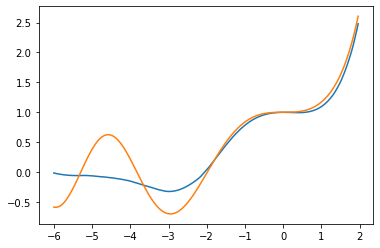

In [5]:
######################################################################
# Routine to solve u''(x) - x*u(x) = f(x), u(0)=A, u'(0)=B in the form
#     u(x) = A + B*x + x^2*N(x,w)
# where N(x,w) is the output of the neural network.
######################################################################

# Create the arrays x and y, where x is a discretization of the domain (a,b) and y is the source term f(x)
N = 200
a = -6.0
b = 2.0
x = np.arange(a, b, (b-a)/N).reshape((N,1))
y = np.zeros(N)

# Boundary conditions
A = 1.0
B = 0.0

# Define the number of neurons in each layer
n_nodes_hl1 = 400
n_nodes_hl2 = 400

# Define the number of outputs and the learning rate
n_classes = 1
learn_rate = 0.00003

# Define input / output placeholders
tf.compat.v1.disable_eager_execution()
x_ph = tf.compat.v1.placeholder('float', [None, 1],name='input')
y_ph = tf.compat.v1.placeholder('float')

# Define standard deviation for the weights and biases
hl_sigma = 0.02

def neural_network_model(data):
    hidden_1_layer = {'weights': tf.Variable(name='w_h1',initial_value=tf.random.normal([1, n_nodes_hl1], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h1',initial_value=tf.random.normal([n_nodes_hl1], stddev=hl_sigma))}

    hidden_2_layer = {'weights': tf.Variable(name='w_h2',initial_value=tf.random.normal([n_nodes_hl1, n_nodes_hl2], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h2',initial_value=tf.random.normal([n_nodes_hl2], stddev=hl_sigma))}

    output_layer = {'weights': tf.Variable(name='w_o',initial_value=tf.random.normal([n_nodes_hl2, n_classes], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_o',initial_value=tf.random.normal([n_classes], stddev=hl_sigma))}


    # (input_data * weights) + biases
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.leaky_relu(l1)   

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    output = tf.add(tf.matmul(l2, output_layer['weights']), output_layer['biases'], name='output')

    return output


batch_size = 32

# Feed batch data
def get_batch(inputX, inputY, batch_size):
    duration = len(inputX)
    for i in range(0,duration//batch_size):
        idx = i*batch_size + np.random.randint(0,10,(1))[0]

        yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size]


# Routine to train the neural network
def train_neural_network_batch(x_ph, predict=False):
    with tf.GradientTape() as gg:
        gg.watch(x_ph)
        with tf.GradientTape() as g:
            g.watch(x_ph)
            prediction = neural_network_model(x_ph)
        pred_dx = g.gradient(prediction,x_ph)    
    pred_dx2 = gg.gradient(pred_dx,x_ph)

    # Compute u and its second derivative
    u = A + B*x_ph + (x_ph*x_ph)*prediction
    dudx2 = (x_ph*x_ph)*pred_dx2 + 2.0*x_ph*pred_dx + 2.0*x_ph*pred_dx + 2.0*prediction

    # The cost function is just the residual of u''(x) - x*u(x) = 0, i.e. residual = u''(x)-x*u(x)
    cost = tf.reduce_mean(tf.square(dudx2-x_ph*u - y_ph))
    optimizer = tf.compat.v1.train.AdamOptimizer(learn_rate).minimize(cost)


    # cycles feed forward + backprop
    hm_epochs = 400

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # Train in each epoch with the whole data
        for epoch in range(hm_epochs):

            epoch_loss = 0
            for step in range(N//batch_size):     ##???
                for inputX, inputY in get_batch(x, y, batch_size):
                    _, l = sess.run([optimizer,cost], feed_dict={x_ph:inputX, y_ph:inputY})
                    epoch_loss += l
            if epoch %10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', epoch_loss)


        # Predict a new input by adding a random number, to check whether the network has actually learned
        x_valid = x + 0.0*np.random.normal(scale=0.1,size=(1))
        return sess.run(tf.compat.v1.squeeze(prediction),{x_ph:x_valid}), x_valid


# Train network
tf.compat.v1.set_random_seed(42)
pred, time = train_neural_network_batch(x_ph)


mypred = pred.reshape(N,1)

# Compute Airy functions for exact solution
ai, aip, bi, bip = special.airy(time)

# Numerical solution vs. exact solution
fig = plt.figure()
plt.plot(time, A + B*time + (time*time)*mypred)
plt.plot(time, 0.5*(3.0**(1/6))*special.gamma(2/3)*(3**(1/2)*ai + bi))
plt.show()

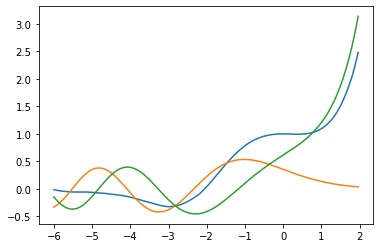

In [14]:
fig = plt.figure()
plt.plot(time, A + B*time + (time*time)*mypred)
plt.plot(time, ai)
plt.plot(time, bi)
plt.show()

ODE:
$$
u''(x) - 2u'(x) +2 u(x) = 0\\
u(0) = 0\\
u'(0) = 1
$$

Assume $u=x+x^2N$, then
$$
x^2 N'' + 4xN' + 2N - 2(1+2xN+x^2N') + 2(x+x^2N) = 0
$$

Exact solution: $u(x)=e^x\sin x$

Epoch 0 completed out of 400 loss: 2114.7465981543064
Epoch 10 completed out of 400 loss: 191.47022242378443
Epoch 20 completed out of 400 loss: 165.11653311736882
Epoch 30 completed out of 400 loss: 140.72279834374785
Epoch 40 completed out of 400 loss: 155.26688615605235
Epoch 50 completed out of 400 loss: 63.25405030883849
Epoch 60 completed out of 400 loss: 44.06258143763989
Epoch 70 completed out of 400 loss: 42.32871188223362
Epoch 80 completed out of 400 loss: 40.33557077497244
Epoch 90 completed out of 400 loss: 44.038587666116655
Epoch 100 completed out of 400 loss: 41.88957878574729
Epoch 110 completed out of 400 loss: 44.42736704740673
Epoch 120 completed out of 400 loss: 46.28833321016282
Epoch 130 completed out of 400 loss: 36.954362583346665
Epoch 140 completed out of 400 loss: 46.27344066579826
Epoch 150 completed out of 400 loss: 49.79594818037003
Epoch 160 completed out of 400 loss: 43.38873598724604
Epoch 170 completed out of 400 loss: 46.699349761009216
Epoch 180 com

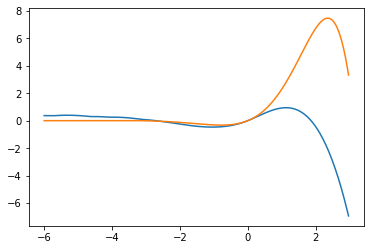

In [27]:
######################################################################
#     u(x) = A + B*x + x^2*N(x,w)
# where N(x,w) is the output of the neural network.
######################################################################

# Create the arrays x and y, where x is a discretization of the domain (a,b) and y is the source term f(x)
N = 300
a = -6.0
b = 3.0
x = np.arange(a, b, (b-a)/N).reshape((N,1))
y = np.zeros(N)

# Boundary conditions
A = 0.0
B = 1.0

# Define the number of neurons in each layer
n_nodes_hl1 = 10
n_nodes_hl2 = 10

# Define the number of outputs and the learning rate
n_classes = 1
learn_rate = 0.003

# Define input / output placeholders
tf.compat.v1.disable_eager_execution()
x_ph = tf.compat.v1.placeholder('float', [None, 1],name='input')
y_ph = tf.compat.v1.placeholder('float')

# Define standard deviation for the weights and biases
hl_sigma = 0.02

def neural_network_model(data):
    hidden_1_layer = {'weights': tf.Variable(name='w_h1',initial_value=tf.random.normal([1, n_nodes_hl1], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h1',initial_value=tf.random.normal([n_nodes_hl1], stddev=hl_sigma))}

    hidden_2_layer = {'weights': tf.Variable(name='w_h2',initial_value=tf.random.normal([n_nodes_hl1, n_nodes_hl2], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h2',initial_value=tf.random.normal([n_nodes_hl2], stddev=hl_sigma))}

    output_layer = {'weights': tf.Variable(name='w_o',initial_value=tf.random.normal([n_nodes_hl2, n_classes], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_o',initial_value=tf.random.normal([n_classes], stddev=hl_sigma))}


    # (input_data * weights) + biases
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.leaky_relu(l1)   

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    output = tf.add(tf.matmul(l2, output_layer['weights']), output_layer['biases'], name='output')

    return output


batch_size = 32

# Feed batch data
def get_batch(inputX, inputY, batch_size):
    duration = len(inputX)
    for i in range(0,duration//batch_size):
        idx = i*batch_size + np.random.randint(0,10,(1))[0]

        yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size]


# Routine to train the neural network
def train_neural_network_batch(x_ph, predict=False):
    with tf.GradientTape() as gg:
        gg.watch(x_ph)
        with tf.GradientTape() as g:
            g.watch(x_ph)
            prediction = neural_network_model(x_ph)
        pred_dx = g.gradient(prediction,x_ph)    
    pred_dx2 = gg.gradient(pred_dx,x_ph)

    # Compute u and its second derivative
    u = A + B*x_ph + (x_ph*x_ph)*prediction
    dudx = B + 2*x_ph*prediction + (x_ph*x_ph)*pred_dx
    dudx2 = (x_ph*x_ph)*pred_dx2 + 2.0*x_ph*pred_dx + 2.0*x_ph*pred_dx + 2.0*prediction

    # The cost function is just the residual of u''(x) - x*u(x) = 0, i.e. residual = u''(x)-x*u(x)
    cost = tf.reduce_mean(tf.square(dudx2-2*dudx+2*u - y_ph))
    optimizer = tf.compat.v1.train.AdamOptimizer(learn_rate).minimize(cost)


    # cycles feed forward + backprop
    hm_epochs = 400

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # Train in each epoch with the whole data
        for epoch in range(hm_epochs):

            epoch_loss = 0
            for step in range(N//batch_size):     ##???
                for inputX, inputY in get_batch(x, y, batch_size):
                    _, l = sess.run([optimizer,cost], feed_dict={x_ph:inputX, y_ph:inputY})
                    epoch_loss += l
            if epoch %10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', epoch_loss)


        # Predict a new input by adding a random number, to check whether the network has actually learned
        x_valid = x + 0.0*np.random.normal(scale=0.1,size=(1))
        return sess.run(tf.compat.v1.squeeze(prediction),{x_ph:x_valid}), x_valid


# Train network
tf.compat.v1.set_random_seed(42)
pred, time = train_neural_network_batch(x_ph)


mypred = pred.reshape(N,1)

# Compute Airy functions for exact solution
# ai, aip, bi, bip = special.airy(time)

# Numerical solution vs. exact solution
fig = plt.figure()
plt.plot(time, A + B*time + (time*time)*mypred)
plt.plot(time, np.exp(time)*np.sin(time))
plt.show()

convert to TensorFlow2.x
https://stackoverflow.com/questions/58986126/replacing-placeholder-for-tensorflow-v2

make_dict[key] = tf.keras.Input(name=key, shape=(), dtype=tf.dtypes.float32)

In [7]:
######################################################################
# Routine to solve u''(x) - x*u(x) = f(x), u(0)=A, u'(0)=B in the form
#     u(x) = A + B*x + x^2*N(x,w)
# where N(x,w) is the output of the neural network.
######################################################################

# Create the arrays x and y, where x is a discretization of the domain (a,b) and y is the source term f(x)
N = 200
a = -6.0
b = 2.0
x = np.arange(a, b, (b-a)/N).reshape((N,1))
y = np.zeros(N)

# Boundary conditions
A = 1.0
B = 0.0

# Define the number of neurons in each layer
n_nodes_hl1 = 400
n_nodes_hl2 = 400

# Define the number of outputs and the learning rate
n_classes = 1
learn_rate = 0.00003

In [8]:
x_ph = tf.keras.Input(name='input', shape=(), dtype=tf.dtypes.float32)
y_ph = tf.keras.Input(name='output', shape=(), dtype=tf.dtypes.float32)

# Define standard deviation for the weights and biases
hl_sigma = 0.02

def neural_network_model(data):
    hidden_1_layer = {'weights': tf.Variable(name='w_h1',initial_value=tf.random.normal([1, n_nodes_hl1], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h1',initial_value=tf.random.normal([n_nodes_hl1], stddev=hl_sigma))}

    hidden_2_layer = {'weights': tf.Variable(name='w_h2',initial_value=tf.random.normal([n_nodes_hl1, n_nodes_hl2], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h2',initial_value=tf.random.normal([n_nodes_hl2], stddev=hl_sigma))}

    output_layer = {'weights': tf.Variable(name='w_o',initial_value=tf.random.normal([n_nodes_hl2, n_classes], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_o',initial_value=tf.random.normal([n_classes], stddev=hl_sigma))}


    # (input_data * weights) + biases
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.leaky_relu(l1)   

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    output = tf.add(tf.matmul(l2, output_layer['weights']), output_layer['biases'], name='output')

    return output

batch_size = 32

# Feed batch data
def get_batch(inputX, inputY, batch_size):
    duration = len(inputX)
    for i in range(0,duration//batch_size):
        idx = i*batch_size + np.random.randint(0,10,(1))[0]

        yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size]

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
var1 = tf.Variable(0.5)
var2 = tf.Variable(0.5)
loss = lambda: (var1**2+var2)/2.0       # d(loss)/d(var1) == var1
step_count = opt.minimize(loss, [var1,var2]).numpy()
# The first step is `-learning_rate*sign(grad)`
var1.numpy(), var2.numpy()

(0.40000063, 0.40000063)

In [ ]:


# Routine to train the neural network
def train_neural_network_batch(x_ph, predict=False):
    with tf.GradientTape() as gg:
        gg.watch(x_ph)
        with tf.GradientTape() as g:
            g.watch(x_ph)
            prediction = neural_network_model(x_ph)
        pred_dx = g.gradient(prediction,x_ph)    
    pred_dx2 = gg.gradient(pred_dx,x_ph)

    # Compute u and its second derivative
    u = A + B*x_ph + (x_ph*x_ph)*prediction
    dudx2 = (x_ph*x_ph)*pred_dx2 + 2.0*x_ph*pred_dx + 2.0*x_ph*pred_dx + 2.0*prediction

    # The cost function is just the residual of u''(x) - x*u(x) = 0, i.e. residual = u''(x)-x*u(x)
    cost = tf.reduce_mean(tf.square(dudx2-x_ph*u - y_ph))
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    opt.minimize(cost, [var1]).numpy()
    
    optimizer = tf.compat.v1.train.AdamOptimizer(learn_rate).minimize(cost)


    # cycles feed forward + backprop
    hm_epochs = 400

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # Train in each epoch with the whole data
        for epoch in range(hm_epochs):

            epoch_loss = 0
            for step in range(N//batch_size):     ##???
                for inputX, inputY in get_batch(x, y, batch_size):
                    _, l = sess.run([optimizer,cost], feed_dict={x_ph:inputX, y_ph:inputY})
                    epoch_loss += l
            if epoch %10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', epoch_loss)


        # Predict a new input by adding a random number, to check whether the network has actually learned
        x_valid = x + 0.0*np.random.normal(scale=0.1,size=(1))
        return sess.run(tf.compat.v1.squeeze(prediction),{x_ph:x_valid}), x_valid


# Train network
tf.compat.v1.set_random_seed(42)
pred, time = train_neural_network_batch(x_ph)


mypred = pred.reshape(N,1)

# Compute Airy functions for exact solution
ai, aip, bi, bip = special.airy(time)

# Numerical solution vs. exact solution
fig = plt.figure()
plt.plot(time, A + B*time + (time*time)*mypred)
plt.plot(time, 0.5*(3.0**(1/6))*special.gamma(2/3)*(3**(1/2)*ai + bi))
plt.show()

In [10]:
np.random.randint(0,10,(1))[0]

8

In [11]:
a = np.array([1,2,3,4,6,8,6,4,4])
a[1:14]

array([2, 3, 4, 6, 8, 6, 4, 4])

In [12]:
len(a)

9